In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
ads_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/shared/homeworks/python_ds_miniprojects/6/ads_data.csv',
                      parse_dates=['date', 'time'])
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [3]:
ads_clients_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/shared/homeworks/python_ds_miniprojects/6/ads_clients_data.csv',
                              parse_dates=['date', 'create_date'])
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [4]:
ads_data.shape

(1000000, 11)

In [5]:
ads_clients_data.shape

(122078, 4)

#### 1. Посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям. 
Тонкий момент: помним, что некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчёта среднего по объявлениям их нужно учитывать. 

In [6]:
mean_values = ads_data.groupby(['ad_id', 'event'], as_index=False) \
                        .agg({'date':'count'}) \
                        .pivot(index='ad_id', columns='event', values='date') \
                        .reset_index() \
                        .fillna(0) \
                        .mean().round(0) \
                        .to_frame().reset_index()
mean_values

,event,0
0,ad_id,57971.0
1,click,113.0
2,view,923.0


#### 2.Посмотрим на распределение показов объявлений. 
Прологарифмируем число показов, а затем построим такой график

In [7]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(25,13)}
        ) #настройки изображения

In [8]:
ads_data_cr = ads_data.query("event == 'view'").groupby(['ad_id', 'event'], as_index=False)\
                      .agg({'time':'count'})
ads_data_cr.head()

,ad_id,event,time
0,2,view,101
1,3,view,184
2,1902,view,41
3,2064,view,35
4,2132,view,58


In [9]:
ads_data_cr['log'] = np.log(ads_data_cr.time)

<AxesSubplot:xlabel='log', ylabel='Density'>

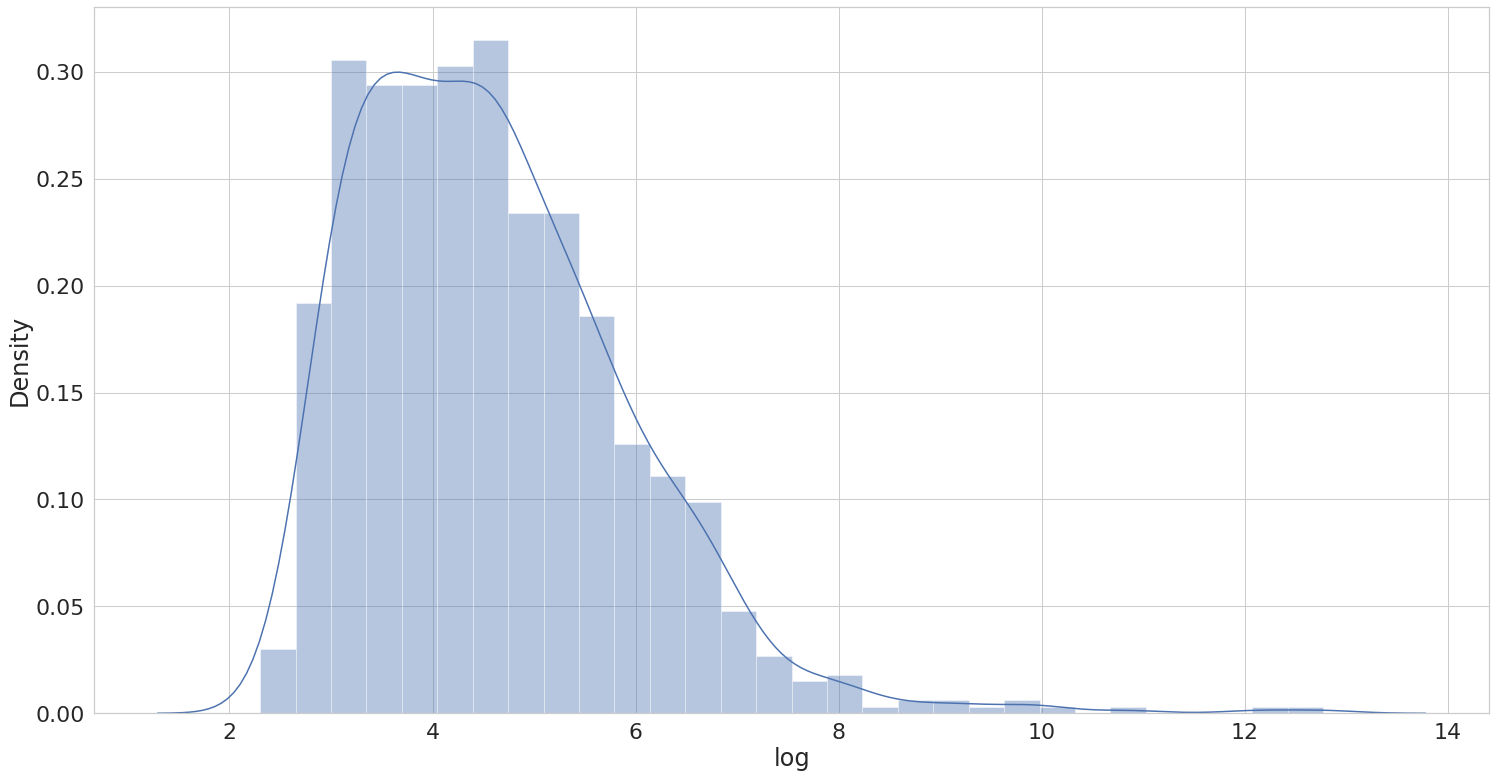

In [10]:
sns.distplot(ads_data_cr.log)

#### 3.Найдем среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитаем скользящее среднее по полученному результату с окном в 2 элемента.

In [11]:
data_view_rolling=ads_data.query('event=="view"') \
                          .groupby(['ad_id','date'], as_index=False) \
                          .agg({'event':'count'}) \
                          .rename(columns={'event':'mean_count_view'}) \
                          .groupby(['date'], as_index=False) \
                          .agg({'mean_count_view':'mean'})

data_view_rolling['rollings']=data_view_rolling.mean_count_view.rolling(2).mean().round(0)
data_view_rolling

,date,mean_count_view,rollings
0,2019-04-01,154.482270,NaN
1,2019-04-02,137.786982,146.0
2,2019-04-03,163.952778,151.0
3,2019-04-04,675.901720,420.0
4,2019-04-05,919.109677,798.0
5,2019-04-06,277.122727,598.0


In [12]:
data_view_rolling.loc[data_view_rolling.date=='2019-04-06']

,date,mean_count_view,rollings
5,2019-04-06,277.122727,598.0


Скользящее среднеее за 6 апреля 2019 года - 598

#### 4.  В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?
Скользящее среднее часто используется для поиска аномалий в данных. Попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных. Дни, в которых скользящее среднее равно NaN, не учитываем.

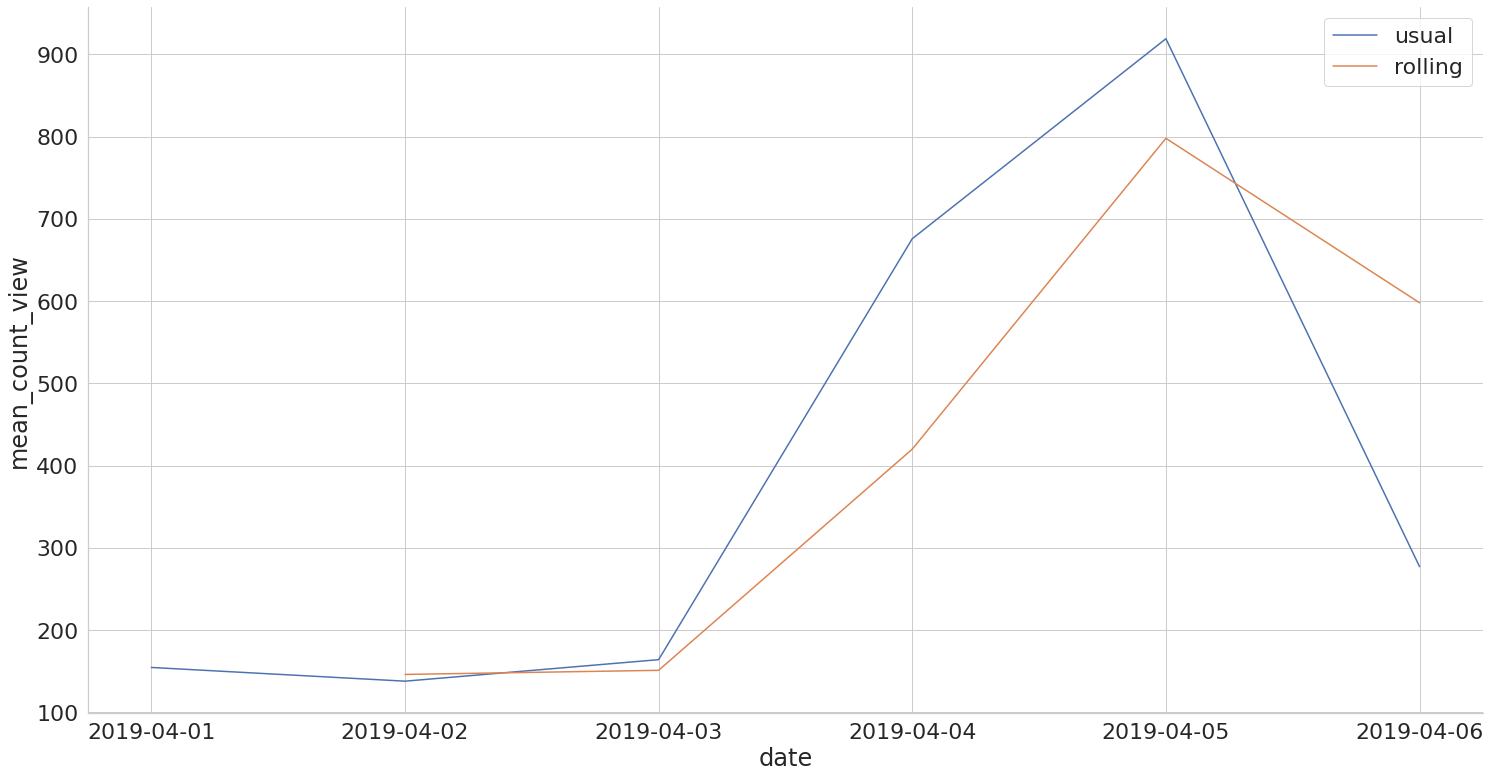

In [15]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='mean_count_view', data=data_view_rolling, label='usual')
sns.lineplot(x='date', y='rollings', data=data_view_rolling, label='rolling')
plt.legend()
sns.despine()

#### 5. Объединим данные рекламы с данными о рекламных клиентах и найдём среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

In [17]:
ads = ads_clients_data.merge(ads_data, on=['client_union_id'], suffixes=('_clients_data', '_ad_data'))
ads.head()

,date_clients_data,client_union_id,community_id,create_date,date_ad_data,time,event,platform,ad_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:08:51,view,android,3,1,CPC,46.7,0,45035
1,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:09:36,view,ios,3,1,CPC,46.7,0,45035
2,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:30,view,ios,3,1,CPC,46.7,0,45035
3,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:58,view,android,3,1,CPC,46.7,0,45035
4,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:51:54,view,android,3,1,CPC,46.7,0,45035


In [18]:
ads['date'] = ads.date_ad_data - ads.create_date

In [19]:
ads.head()

,date_clients_data,client_union_id,community_id,create_date,date_ad_data,time,event,platform,ad_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date
0,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:08:51,view,android,3,1,CPC,46.7,0,45035,98 days
1,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:09:36,view,ios,3,1,CPC,46.7,0,45035,98 days
2,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:30,view,ios,3,1,CPC,46.7,0,45035,98 days
3,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:58,view,android,3,1,CPC,46.7,0,45035,98 days
4,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:51:54,view,android,3,1,CPC,46.7,0,45035,98 days


In [25]:
ads_min = ads.groupby('client_union_id', as_index=False).agg({'date':'min'}) 

In [26]:
ads_min.date.mean()

Timedelta('124 days 09:04:43.532219570')

Cреднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом - 124

#### 6.Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов.

In [27]:
ads_year = ads_min.query('date<"365d" and date!="NaT"')
ads_year.shape

(838, 2)

In [30]:
round(ads_year.date.count()/ads_clients_data.client_union_id.nunique()*100, 2)
#конверсия из создания рекламного в запуск первой рекламы

0.69

#### 7. Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления

In [31]:
bins = pd.to_timedelta([0, 30, 90, 180, 365], unit = 'd')
ads['date'] = pd.cut(ads.date, bins=bins, labels = ['0-30 days', '30-90 days', '90-180 days', '180-365 days'])

In [38]:
nunique = ads.groupby('date', as_index=False)\
    .agg({'client_union_id': 'nunique'})

In [39]:
nunique

,date,client_union_id
0,0-30 days,11
1,30-90 days,265
2,90-180 days,399
3,180-365 days,169


#### 8. Построим интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них 

In [40]:
px.bar(x=nunique.date, y=nunique.client_union_id)

 11 уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней)